# Explore Performance of LogReg with different datasets

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix

## Load and transform datasets into numpy arrays

In [2]:
# amplies necessary transformation of df to numpy matrix
def convert2numpy(labels, features_ff, features_cs, features_tf, df = False):
    # define lists to convert to binary
    cancer_list = ["A", "B", "C", "Lung", "Breast"]
    gender_list = ["male"]
    # convert to binary and drop 
    labels["cancer"] = np.where(labels["diagnosis"].isin(cancer_list), 1, 0)
    features_tf["gender_binary"] = np.where(features_tf["gender"].isin(gender_list), 1, 0)
    labels.drop(columns = ["diagnosis"], inplace = True)
    features_tf.drop(columns =  ["gender"], inplace = True)
    # to wide format and set sampls as indices
    features_ff = features_ff.pivot(index = "sample", columns = ["length"], values = "count")
    features_cs = features_cs.pivot(index = "sample", columns = ["region-set"], values = ["Dip_area", "Dip_depth"])
    features_cs.columns = [i[0] + "_" + i[1] for i in features_cs.columns]
    features_cs[features_cs.index != "EE87952"]
    features_tf.set_index("sample", inplace = True)
    labels.set_index("sample", inplace = True)
    # sort indices
    index = [index for index in labels.index if index in list(features_tf.index) and list(features_ff.index) and list(features_cs.index)]
    features_ff = features_ff.loc[index]
    features_tf = features_tf.loc[index]
    features_cs = features_cs.loc[index]
    labels = labels.loc[index]
    
    # only return if function worked and everthing is in right order
    if np.array([np.array_equal(labels.index, features_ff.index), 
                 np.array_equal(labels.index, features_tf.index), 
                 np.array_equal(labels.index, features_cs.index)]).all():
        
        
        
        labels_np = labels.to_numpy(copy=True)
        features_ff_np = features_ff.to_numpy(copy=True)
        features_tf_np = features_tf.to_numpy(copy=True)
        features_cs_np = features_cs.to_numpy(copy=True)
            
            
        return labels, features_ff, features_cs, features_tf, labels_np, features_ff_np, features_cs_np, features_tf_np

# splits labels and features into train and test sets and normalizes
def splitter(labels, features):
    # split into train test
    X, y = features, labels.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle = True)
    # normalize
    transformer = StandardScaler().fit(X_train) # compute mean, std on train
    X_test = transformer.transform(X_test)  # use same transformer for both, mimics that we do not know train data
    X_train = transformer.transform(X_train)
    
    return X_train, X_test, y_train, y_test

def LogReg(labels, features, C):
    
    X_train, X_test, y_train, y_test = splitter(labels, features)
    logReg = LogisticRegression(penalty = "l1", solver = "liblinear", C = C) # bigger C lower pen -> 1 / C
    logReg.fit(X_train, y_train)
    train_predict  =logReg.predict(X_train)
    test_predict = logReg.predict(X_test)
    f1_train = f1_score(y_train, train_predict)
    f1_test = f1_score(y_test, test_predict)
    f1_delta = abs(f1_train - f1_test)
    
    return f1_train, f1_test, f1_delta
    


# perfomrs kFold method with KNN, logisticRegression, random Forrest
def CV_analysis(labels, features, n_params, t_knn, t_logReg, t_ranFor):
    # defining future dictionaries
    F1_matrix_knn = {"n_neighbors": []}
    F1_matrix_logReg = {"C_value": []}
    F1_matrix_ranFor = {"n_estimators": []}
    
    # split into train and test
    X, y = features, labels.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle = True)

    kf = KFold(n_splits=5, shuffle=True, random_state=33)
    split_ = kf.split(X_train)


    for index, (i_train, i_valid) in enumerate(split_):
        # splitting into train and validation set
        X_train, X_valid = X[i_train], X[i_valid]
        y_train, y_valid = y[i_train], y[i_valid]
        
        transformer = StandardScaler().fit(X_train) # compute mean, std on train
        X_valid = transformer.transform(X_valid)  # use same transformer for both, mimics that we do not know train data
        X_train = transformer.transform(X_train)

        # loop through each classifier, fit and predict the validation set

        for n_neighbors in np.linspace(t_knn[0], t_knn[1], n_params, dtype = "int"):

            # construct new Fi columns if i doesnt exist     
            if "F" + str(index+1) not in F1_matrix_knn.keys():
                F1_matrix_knn["F" + str(index+1)] = []

            # fit and predict with classifier
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)
            y_predict = knn.predict(X_valid)

            # insert F1 value in matrix
            F1_matrix_knn["F" + str(index+1)].append(f1_score(y_valid, y_predict, average = "macro"))

            # for index labeling with paramters
            if n_neighbors not in F1_matrix_knn["n_neighbors"]:
                F1_matrix_knn["n_neighbors"].append(n_neighbors)
                
           # print("KNN: {} accuracy train: {} vs. valid {}".format(n_neighbors,
           #                                                      accuracy_score(y_train, knn.predict(X_train)),
           #                                                      accuracy_score(y_valid, knn.predict(X_valid))))
            
            

        # same as above        
        for C_value in np.linspace(t_logReg[0], t_logReg[1], n_params):


            if "F" + str(index+1) not in F1_matrix_logReg.keys():

                F1_matrix_logReg["F" + str(index+1)] = []

            logReg = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 1000, C = C_value)
            logReg.fit(X_train, y_train)
            y_predict = logReg.predict(X_valid)

            F1_matrix_logReg["F" + str(index+1)].append(f1_score(y_valid, y_predict, average = "macro"))

            if C_value not in F1_matrix_logReg["C_value"]:
                F1_matrix_logReg["C_value"].append(C_value)
                
            # print("LogReg: {} accuracy train: {} vs. valid {}".format(C_value,
            #                                                     accuracy_score(y_train, logReg.predict(X_train)),
            #                                                     accuracy_score(y_valid, logReg.predict(X_valid))))

        # same as above        
        for n_estimators in np.linspace(t_ranFor[0], t_ranFor[1], n_params, dtype = "int"):


            if "F" + str(index+1) not in F1_matrix_ranFor.keys():

                F1_matrix_ranFor["F" + str(index+1)] = []

            ranFor = RandomForestClassifier(n_estimators = n_estimators, max_depth = 6) 
            ranFor.fit(X_train, y_train)
            y_predict = ranFor.predict(X_valid)

            F1_matrix_ranFor["F" + str(index+1)].append(f1_score(y_valid, y_predict, average = "macro"))

            if n_estimators not in F1_matrix_ranFor["n_estimators"]:
                F1_matrix_ranFor["n_estimators"].append(n_estimators)
                
            # print("ranFor: {} accuracy train: {} vs. valid {}".format(n_estimators,
            #                                                      accuracy_score(y_train, ranFor.predict(X_train)),
            #                                                      accuracy_score(y_valid, ranFor.predict(X_valid))))


    # some transforms and add stats
    F1_knn = pd.DataFrame(F1_matrix_knn)
    F1_knn.set_index("n_neighbors", inplace = True)

    F1_logReg = pd.DataFrame(F1_matrix_logReg)
    F1_logReg.set_index("C_value", inplace = True)

    F1_ranFor = pd.DataFrame(F1_matrix_ranFor)
    F1_ranFor.set_index("n_estimators", inplace = True)
    
    F1_knn = F1_knn.assign(mean = F1_knn.iloc[:, :5].mean(axis=1)) # assign add a column to df
    F1_knn = F1_knn.assign(sd = F1_knn.iloc[:, :5].std(axis = 1))
    F1_knn = F1_knn.round(decimals = 4)

    F1_logReg = F1_logReg.assign(mean = F1_logReg.iloc[:, :5].mean(axis=1)) # assign add a column to df
    F1_logReg = F1_logReg.assign(sd = F1_logReg.iloc[:, :5].std(axis = 1))
    F1_logReg = F1_logReg.round(decimals = 4)

    F1_ranFor = F1_ranFor.assign(mean = F1_ranFor.iloc[:, :5].mean(axis=1)) # assign add a column to df
    F1_ranFor = F1_ranFor.assign(sd = F1_ranFor.iloc[:, :5].std(axis = 1))
    F1_ranFor = F1_ranFor.round(decimals = 4)
    # F1_knn, F1_logReg, F1_ranFor = F1_matrix_knn, F1_matrix_logReg, F1_matrix_ranFor
    
    return F1_knn, F1_logReg, F1_ranFor

def CV_LogReg(labels, features, Cs):
        # defining future dictionaries
    F1_matrix_logReg = {"C": []}
    markers = dict([[str(round(1 / C, 2)), "0"] for C in Cs])
    
    # split into train and test
    X, y = features, labels.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle = True)

    kf = KFold(n_splits=5, shuffle=True, random_state=33)
    split_ = kf.split(X_train)


    for index, (i_train, i_valid) in enumerate(split_):
        # splitting into train and validation set
        X_train, X_valid = X[i_train], X[i_valid]
        y_train, y_valid = y[i_train], y[i_valid]
        
        transformer = StandardScaler().fit(X_train) # compute mean, std on train
        X_valid = transformer.transform(X_valid)  # use same transformer for both, mimics that we do not know train data
        X_train = transformer.transform(X_train)
        
        for C in Cs:

            if "F1_train_" + str(index+1) not in F1_matrix_logReg.keys():

                F1_matrix_logReg["F1_train_" + str(index+1)] = []
                F1_matrix_logReg["F1_valid_" + str(index+1)] = []
                F1_matrix_logReg["nonzero_coef_" + str(index+1)] = []
                

            logReg = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 1000, C = C)
            logReg.fit(X_train, y_train)
            train_predict = logReg.predict(X_train)
            valid_predict = logReg.predict(X_valid)
            nonzeros = logReg.coef_[0].nonzero()[0]
            
            F1_matrix_logReg["F1_train_" + str(index+1)].append(f1_score(y_train, train_predict, average = "macro"))
            F1_matrix_logReg["F1_valid_" + str(index+1)].append(f1_score(y_valid, valid_predict, average = "macro"))
            F1_matrix_logReg["nonzero_coef_" + str(index+1)].append(len(nonzeros))
            # print("coef:", logReg.coef_[0].nonzero())
            
            if str(round(1 / C, 2)) not in F1_matrix_logReg["C"]:
                F1_matrix_logReg["C"].append(str(round(1 / C, 2)))
                
        
            markers[str(round(1 / C, 2))] = nonzeros # attention: stores result for fold 5
                
    F1_logReg = pd.DataFrame(F1_matrix_logReg)
    F1_logReg.set_index("C", inplace = True)
    F1_logReg = F1_logReg.assign(mean_zerocoef = F1_logReg.iloc[:, 2::3].mean(axis=1)) # assign add a column to df
    # F1_logReg = F1_logReg.assign(sd = F1_logReg.iloc[:, :5].std(axis = 1))
    F1_logReg = F1_logReg.round(decimals = 4)
                

    return F1_logReg, markers
    
def binary(df, key, features = False):
    
    df = df.copy()
    
    if key != "cancer":     
        df = df[(df["diagnosis"] == "Healthy") | (df["diagnosis"] == key)]
        
    if key == "cancer":
        key = ["A", "B", "C", "Lung", "Breast"]
        
    else:
        key = [key]
        
    
    if features == False:    
        df["cancer"] = np.where(df["diagnosis"].isin(key), 1, 0)
        df.drop(columns = ["diagnosis"], inplace = True)
        df.set_index("sample", inplace = True)
            
    else:
        df.drop(columns = ["diagnosis"], inplace = True)
        df = df.pivot(index = "sample", columns = ["length"], values = "count")
        
    
    
    # df.drop(columns = ["diagnosis"], inplace = True)
    
    df.sort_index(inplace = True)
    
    array = df.to_numpy(copy=True)
    
    if features == False:
        return df, array.ravel()
    
    else:
        return df, array
        
    
    
    


In [3]:
labels = pd.read_csv("Results/Machine_Learning/sample_map_ML.csv")
features_ff  = pd.read_csv("Results/Machine_Learning/fragment_features_CNA_ML.csv")
features_cs  = pd.read_csv("Results/Machine_Learning/cell_type_signatures_LIQ_ML.csv")
features_tf  = pd.read_csv("Results/Machine_Learning/tumour_fractions_ML.csv")

labels_df, features_ff_df, features_cs_df, features_tf_df, labels, features_ff, features_cs, features_tf = convert2numpy(labels, features_ff, features_cs, features_tf, df = False)

## Testing C-values, overfitting for different features 

### Fragment length

In [4]:
Cs = np.array([0.05, 0.1, 1, 2, 6, 10, 100, 1000])  # penalty is 1 / C
n_params = 10
ff_df, ff_markers = CV_LogReg(labels, features_ff, Cs)

In [5]:
ff_df

,F1_train_1,F1_valid_1,nonzero_coef_1,F1_train_2,F1_valid_2,nonzero_coef_2,F1_train_3,F1_valid_3,nonzero_coef_3,F1_train_4,F1_valid_4,nonzero_coef_4,F1_train_5,F1_valid_5,nonzero_coef_5,mean_zerocoef
C,,,,,,,,,,,,,,,,
20.0,0.5908,0.5835,2,0.4906,0.3937,2,0.4543,0.5373,2,0.5699,0.4571,2,0.4088,0.3871,1,1.8
10.0,0.7474,0.6814,3,0.7105,0.5565,5,0.6516,0.7493,4,0.7278,0.6688,4,0.6149,0.6842,4,4.0
1.0,0.8293,0.8187,11,0.8443,0.7054,9,0.8419,0.8504,11,0.8350,0.8455,11,0.8192,0.8510,10,10.4
0.5,0.8551,0.8798,12,0.8663,0.7175,12,0.8566,0.8690,11,0.8611,0.8690,11,0.8573,0.8510,11,11.4
0.17,0.8997,0.8798,17,0.8849,0.7959,16,0.8864,0.8837,17,0.8900,0.9045,21,0.8959,0.8946,19,18.0
0.1,0.9229,0.8987,27,0.9172,0.8487,22,0.9069,0.9169,26,0.9188,0.8871,25,0.9168,0.8946,27,25.4
0.01,0.9888,0.9193,62,0.9924,0.8839,66,0.9812,0.9690,64,0.9963,0.8871,61,0.9807,0.9276,62,63.0
0.0,1.0000,0.9045,106,1.0000,0.8839,110,1.0000,0.9690,105,1.0000,0.8871,109,1.0000,0.9123,102,106.4


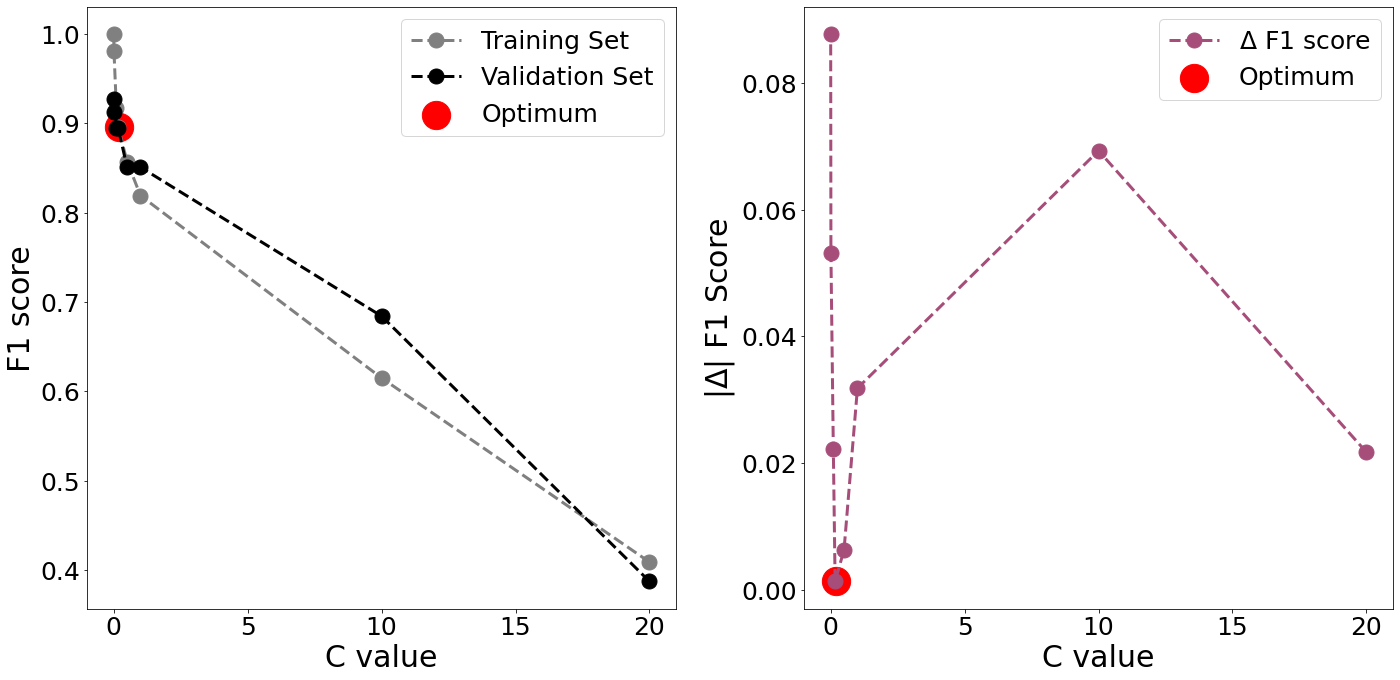

<Figure size 432x288 with 0 Axes>

In [23]:
# we choose fold 5

plt.rcParams.update({'font.size': 25})
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
plt.subplots_adjust(wspace = 0.5)

ax1.plot((1 / Cs), ff_df["F1_train_5"], marker = "o", linestyle = "--", color = "gray", label = "Training Set", lw = 3, ms = 15)
ax1.plot((1 / Cs), ff_df["F1_valid_5"], marker = "o", linestyle = "--", color = "black", label = "Validation Set", ms = 15, lw = 3)
ax1.scatter(0.2, ff_df.iloc[4, 12], c = "red", s = 800, label = "Optimum") # update
ax1.set_xlabel("C value", fontsize = 30)
ax1.set_ylabel("F1 score", fontsize = 30)

ax2.plot(1 / Cs, (abs(ff_df["F1_train_5"] - ff_df["F1_valid_5"])), marker = "o", linestyle = "--", color = "#a64d79", label = "${\Delta}$ F1 score",  lw = 3, ms = 15) # plot a delta
ax2.scatter(0.2, abs(ff_df["F1_train_5"] - ff_df["F1_valid_5"]).iloc[4], c = "red", s = 800, label = "Optimum")
ax2.set_xlabel("C value", fontsize = 30)
ax2.set_ylabel("|${\Delta}$| F1 Score", fontsize = 30)
ax1.legend()
ax2.legend()
plt.tight_layout()
#plt.vline(x = 12)
# plt.xlim(0,20)
plt.savefig("Reasoning_C-choice.png", facecolor = "w", dpi = 400)
plt.show()
plt.clf() # best C is C = 0.1

In [11]:
# features_ff_df.set_index("sample", inplace = True)
mark = list(features_ff_df.columns[list(ff_markers["0.17"])])
# use this list for vline plots
mark
ff_columns = mark.copy()

In [12]:
mark

[106,
 111,
 116,
 123,
 128,
 129,
 136,
 137,
 141,
 142,
 152,
 156,
 165,
 170,
 171,
 181,
 202,
 217]

In [13]:
features_ff_df = features_ff_df.div(features_ff_df.sum(axis=1), axis=0)

In [14]:
samplemap = pd.read_csv("Results/Machine_Learning/sample_map_ML.csv")
features_ff_df = features_ff_df.merge(samplemap, on = "sample", how = "inner")

In [15]:
ff_mean = {}
diagnosis = features_ff_df["diagnosis"].unique()

for d in diagnosis:
    
    ff_mean[d] = np.array(features_ff_df[features_ff_df["diagnosis"] == d].mean(axis = 0))

C:\Users\paesc\AppData\Local\Temp\ipykernel_22564\436343005.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ff_mean[d] = np.array(features_ff_df[features_ff_df["diagnosis"] == d].mean(axis = 0))


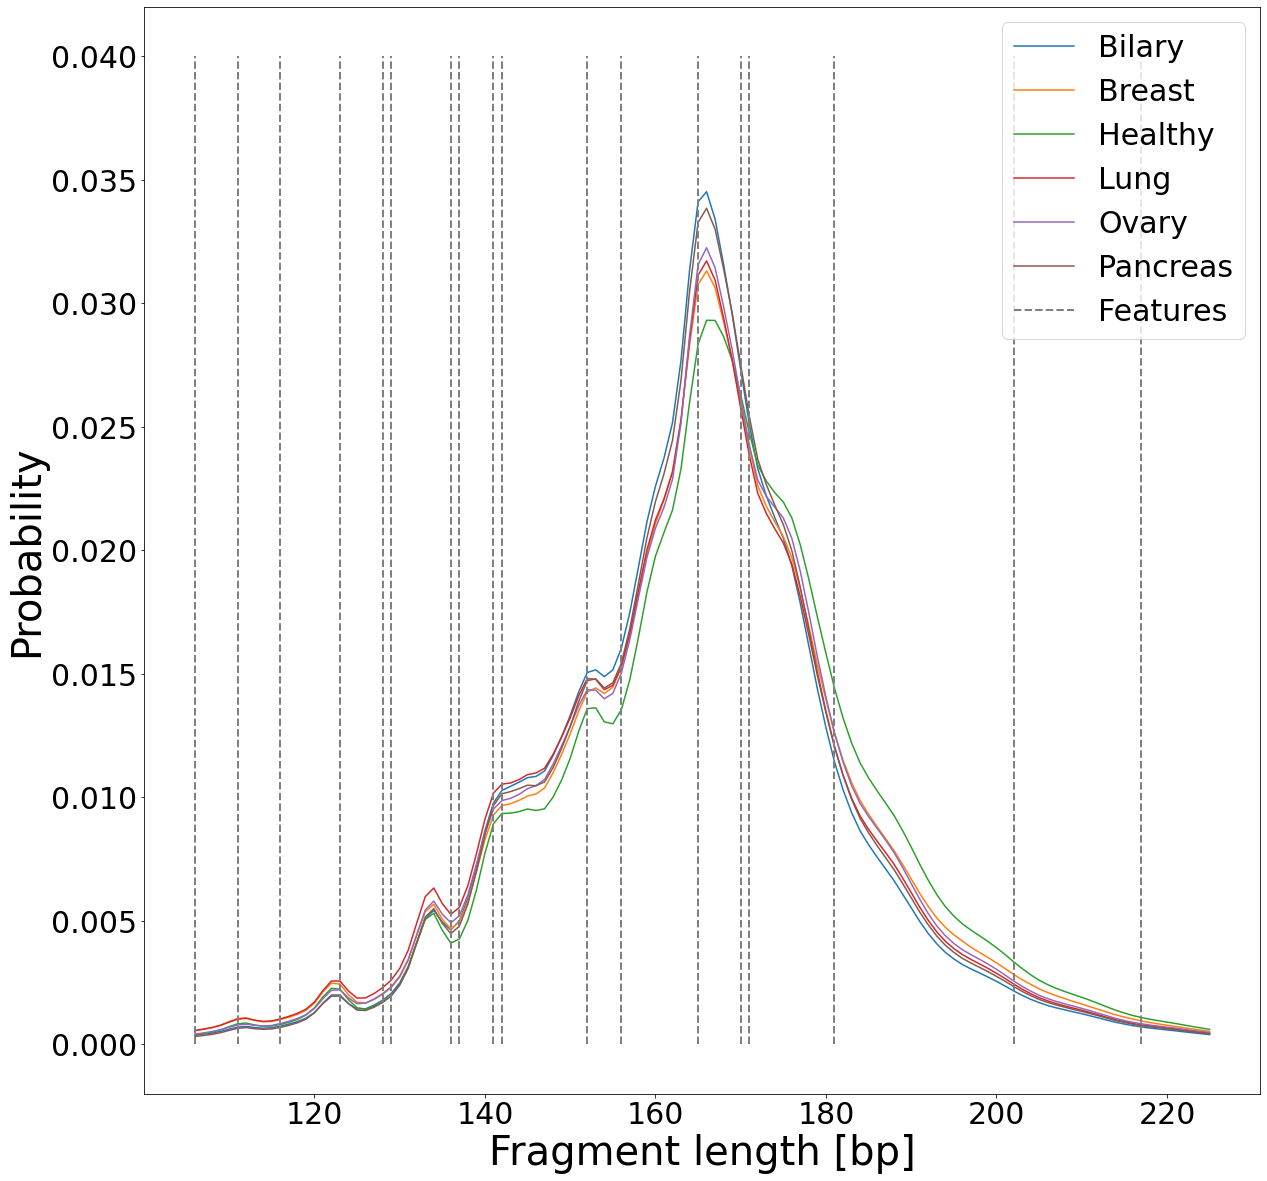

In [35]:
# normalize per sample before you plt adn order labels
plt.rcParams.update({'font.size': 30})
plt.figure(figsize = (20, 20))
labels =  ["Bilary", "Breast", "Healthy", "Lung", "Ovary", "Pancreas", "Features"]

for i, key in enumerate(ff_mean.keys()):
    plt.plot(list(range(106, 226)), ff_mean[key], label = labels[i])
    
plt.vlines(x = mark, ymin = 0, ymax = 0.04, color = "grey", linestyle = "--", label = "Features", linewidth = 2)

plt.xlabel("Fragment length [bp]", fontsize = 40)
plt.ylabel("Probability", fontsize = 40)
plt.legend()

plt.savefig("ff_distribution_important_features.png", facecolor = "w", dpi = 400)

### ichorCNA: tumour fracitons

In [217]:
Cs = np.array([0.02, 0.05, 0.1, 1, 2, 5, 100, 1000])  # penalty is 1 / C
n_params = 10
tf_df, tf_markers = CV_LogReg(labels, features_tf, Cs)

In [218]:
Cs_tf = "10.0"
tf_columns = list(features_tf_df.columns[list(tf_markers["10.0"])])
tf_df

,F1_train_1,F1_valid_1,nonzero_coef_1,F1_train_2,F1_valid_2,nonzero_coef_2,F1_train_3,F1_valid_3,nonzero_coef_3,F1_train_4,F1_valid_4,nonzero_coef_4,F1_train_5,F1_valid_5,nonzero_coef_5,mean_zerocoef
C,,,,,,,,,,,,,,,,
50.0,0.4121,0.4633,1,0.4505,0.4325,1,0.4027,0.4122,1,0.7018,0.5650,2,0.5100,0.4601,2,1.4
20.0,0.6427,0.7239,2,0.6694,0.5471,2,0.6448,0.7554,2,0.6943,0.5284,2,0.6365,0.6491,2,2.0
10.0,0.6585,0.7239,2,0.6792,0.6265,3,0.6702,0.7768,3,0.7115,0.5284,3,0.6722,0.6268,2,2.6
1.0,0.6997,0.7825,3,0.7097,0.7081,3,0.7089,0.7580,3,0.7484,0.5635,3,0.7134,0.6919,3,3.0
0.5,0.6997,0.7825,3,0.7066,0.6961,3,0.7089,0.7580,3,0.7484,0.5635,3,0.7195,0.6919,3,3.0
0.2,0.6997,0.7825,3,0.7066,0.6961,3,0.7089,0.7580,3,0.7536,0.5635,3,0.7163,0.6919,3,3.0
0.01,0.6997,0.7825,3,0.7124,0.6961,3,0.7089,0.7580,3,0.7536,0.5635,3,0.7131,0.6919,3,3.0
0.0,0.6997,0.7825,3,0.7124,0.6961,3,0.7089,0.7580,3,0.7536,0.5635,3,0.7131,0.6919,3,3.0


### LIQUORICE

In [219]:
Cs = np.array([0.05, 0.1, 1, 2, 5, 100, 1000])  # penalty is 1 / C
n_params = 10
df_cs, cs_markers = CV_LogReg(labels, features_cs, Cs)

In [220]:
C_cs = "10.0"
df_cs

,F1_train_1,F1_valid_1,nonzero_coef_1,F1_train_2,F1_valid_2,nonzero_coef_2,F1_train_3,F1_valid_3,nonzero_coef_3,F1_train_4,F1_valid_4,nonzero_coef_4,F1_train_5,F1_valid_5,nonzero_coef_5,mean_zerocoef
C,,,,,,,,,,,,,,,,
20.0,0.7472,0.7100,6,0.7004,0.6375,4,0.7202,0.7332,5,0.7011,0.7100,4,0.6888,0.5723,2,4.2
10.0,0.7609,0.7332,9,0.7422,0.6623,7,0.7211,0.6620,7,0.7358,0.7462,7,0.7454,0.6766,8,7.6
1.0,0.7813,0.7081,24,0.7706,0.7397,22,0.7658,0.6738,24,0.7706,0.6737,24,0.7720,0.7827,25,23.8
0.5,0.7813,0.6961,26,0.7706,0.7276,23,0.7706,0.6856,25,0.7674,0.6737,25,0.7720,0.7989,26,25.0
0.2,0.7813,0.6961,26,0.7755,0.7038,24,0.7595,0.6856,25,0.7767,0.6737,25,0.7655,0.7989,26,25.2
0.01,0.7767,0.6961,26,0.7722,0.7038,26,0.7595,0.6856,26,0.7846,0.6737,26,0.7622,0.7827,26,26.0
0.0,0.7767,0.6961,26,0.7722,0.7038,26,0.7595,0.6856,26,0.7846,0.6737,26,0.7622,0.7827,26,26.0


In [86]:
cs_columns = list(features_cs_df.columns[list(cs_markers[C_cs])])

## Our combined models

### fragment length only

In [221]:
# features_ff_df.set_index("sample", inplace = True)
features_ff1 = features_ff_df[ff_columns].to_numpy(copy=True)

In [238]:
n_params = 3
t_knn, t_logReg, t_ranFor = (4, 6), (5, 10), (10, 20)

F1_knn, F1_logReg, F1_ranFor = CV_analysis(labels, features_ff1 , n_params, t_knn, t_logReg, t_ranFor)

In [239]:
F1_logReg, F1_knn, F1_ranFor

(             F1      F2      F3      F4      F5    mean      sd
 C_value                                                        
 5.0      0.8798  0.8681  0.9018  0.9045  0.8782  0.8865  0.0159
 10.0     0.9325  0.8815  0.9364  0.8901  0.9106  0.9102  0.0245
 15.0     0.9325  0.8815  0.9364  0.8901  0.8967  0.9074  0.0252,
                  F1      F2      F3      F4      F5    mean      sd
 n_neighbors                                                        
 4            0.7735  0.7507  0.8690  0.7462  0.7998  0.7879  0.0501
 5            0.7597  0.7136  0.8727  0.7768  0.8173  0.7880  0.0602
 6            0.7239  0.7425  0.8871  0.7688  0.8264  0.7897  0.0668,
                   F1      F2      F3      F4      F5    mean      sd
 n_estimators                                                        
 10            0.8253  0.7520  0.8901  0.7580  0.8808  0.8212  0.0654
 15            0.7735  0.7703  0.8760  0.7974  0.8645  0.8163  0.0505
 20            0.7966  0.7520  0.8901  0.8363  0

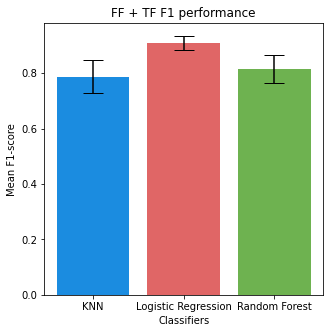

<Figure size 432x288 with 0 Axes>

In [245]:
summary = pd.DataFrame({"classifier": ["KNN", "Logistic Regression", "Random Forest"],
                        "mean_F1": [F1_knn.iloc[1, 5], F1_logReg.iloc[1, 5], F1_ranFor.iloc[1, 5]],
                       "std_F1": [F1_knn.iloc[1, 6], F1_logReg.iloc[1, 6], F1_ranFor.iloc[1, 6]]})

plt.figure(figsize = (5,5))
plt.bar(data = summary, x = "classifier", height = "mean_F1", yerr = "std_F1", color = ["#1b8ce0", "#e06666", "#6eb250"],
        capsize=10)
plt.title("FF + TF F1 performance")
plt.xlabel("Classifiers")
plt.ylabel("Mean F1-score") # put definition of macro F1 score, sensitivity and specificity -> doesnt favour one level over the other
plt.show()
plt.clf()

### fragment length and ichorCNA

In [190]:
df_combi_ff_tf = features_ff_df[ff_columns].merge(features_tf_df[tf_columns], on = "sample", how = "inner")
df_combi_ff_tf.set_index("sample", inplace = True)
combi_ff_tf = df_combi_ff_tf.to_numpy(copy = True)
print("No info loss? ", len(combi_ff_tf) == len(features_ff_df[ff_columns]) == len(features_tf_df[tf_columns]))

No info loss?  True


In [129]:
n_params = 3
t_knn, t_logReg, t_ranFor = (4, 6), (6, 30), (10, 20)

F1_knn, F1_logReg, F1_ranFor = CV_analysis(labels, combi_ff_tf, n_params, t_knn, t_logReg, t_ranFor)

In [130]:
F1_logReg, F1_knn, F1_ranFor

(             F1      F2      F3      F4      F5    mean      sd
 C_value                                                        
 6.0      0.8952  0.8418  0.9045  0.9018  0.8645  0.8816  0.0274
 18.0     0.8952  0.8418  0.9070  0.8871  0.8645  0.8791  0.0260
 30.0     0.8952  0.8418  0.9070  0.8871  0.8645  0.8791  0.0260,
                  F1      F2      F3      F4      F5    mean      sd
 n_neighbors                                                        
 4            0.6844  0.7081  0.8871  0.8111  0.8264  0.7834  0.0849
 5            0.6722  0.7298  0.8727  0.7974  0.8441  0.7832  0.0823
 6            0.7102  0.7205  0.8727  0.7904  0.8264  0.7840  0.0693,
                   F1      F2     F3      F4      F5    mean      sd
 n_estimators                                                       
 10            0.7966  0.8184  0.876  0.8311  0.8696  0.8384  0.0339
 15            0.8043  0.7830  0.907  0.7839  0.8808  0.8318  0.0581
 20            0.8187  0.7755  0.907  0.7974  0.8808

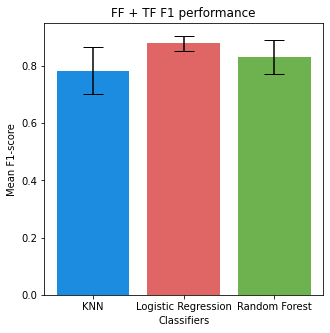

<Figure size 432x288 with 0 Axes>

In [132]:
summary = pd.DataFrame({"classifier": ["KNN", "Logistic Regression", "Random Forest"],
                        "mean_F1": [F1_knn.iloc[1, 5], F1_logReg.iloc[1, 5], F1_ranFor.iloc[1, 5]],
                       "std_F1": [F1_knn.iloc[1, 6], F1_logReg.iloc[1, 6], F1_ranFor.iloc[1, 6]]})

plt.figure(figsize = (5,5))
plt.bar(data = summary, x = "classifier", height = "mean_F1", yerr = "std_F1", color = ["#1b8ce0", "#e06666", "#6eb250"],
        capsize=10)
plt.title("FF + TF F1 performance")
plt.xlabel("Classifiers")
plt.ylabel("Mean F1-score") # put definition of macro F1 score, sensitivity and specificity -> doesnt favour one level over the other
plt.show()
plt.clf()

### fragment length and LIQUORICE

In [133]:
df_combi_ff_cs = features_ff_df[ff_columns].merge(features_cs_df[cs_columns], on = "sample", how = "inner")
df_combi_ff_cs.set_index("sample", inplace = True)
combi_ff_cs = df_combi_ff_cs.to_numpy(copy = True)
print("No info loss? ", len(combi_ff_cs) == len(features_ff_df[ff_columns]) == len(features_cs_df[cs_columns]))

No info loss?  True


In [149]:
n_params = 3
t_knn, t_logReg, t_ranFor = (4, 6), (5, 15), (11, 17)

F1_knn, F1_logReg, F1_ranFor = CV_analysis(labels, combi_ff_cs, n_params, t_knn, t_logReg, t_ranFor)

In [150]:
F1_logReg, F1_knn, F1_ranFor

(             F1      F2      F3      F4      F5    mean      sd
 C_value                                                        
 5.0      0.8798  0.8130  0.8727  0.8871  0.9003  0.8706  0.0338
 10.0     0.8952  0.8418  0.8727  0.8871  0.9003  0.8794  0.0235
 15.0     0.8755  0.8418  0.8727  0.8690  0.9003  0.8719  0.0208,
                  F1      F2      F3      F4      F5    mean      sd
 n_neighbors                                                        
 4            0.6814  0.6487  0.8043  0.7227  0.8306  0.7375  0.0781
 5            0.6814  0.6976  0.8649  0.7904  0.8478  0.7764  0.0842
 6            0.6814  0.6976  0.8455  0.7462  0.8614  0.7664  0.0831,
                   F1      F2      F3      F4      F5    mean      sd
 n_estimators                                                        
 11            0.7825  0.8010  0.8901  0.8363  0.8672  0.8354  0.0447
 14            0.7735  0.7456  0.9045  0.8548  0.8672  0.8291  0.0668
 17            0.7966  0.7456  0.8901  0.7773  0

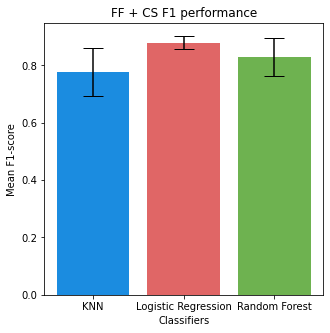

<Figure size 432x288 with 0 Axes>

In [151]:
summary = pd.DataFrame({"classifier": ["KNN", "Logistic Regression", "Random Forest"],
                        "mean_F1": [F1_knn.iloc[1, 5], F1_logReg.iloc[1, 5], F1_ranFor.iloc[1, 5]],
                       "std_F1": [F1_knn.iloc[1, 6], F1_logReg.iloc[1, 6], F1_ranFor.iloc[1, 6]]})

plt.figure(figsize = (5,5))
plt.bar(data = summary, x = "classifier", height = "mean_F1", yerr = "std_F1", color = ["#1b8ce0", "#e06666", "#6eb250"],
        capsize=10)
plt.title("FF + CS F1 performance")
plt.xlabel("Classifiers")
plt.ylabel("Mean F1-score") # put definition of macro F1 score, sensitivity and specificity -> doesnt favour one level over the other
plt.show()
plt.clf()

### LIQUORICE and ichorCNA

In [165]:
df_combi_tf_cs = features_tf_df[tf_columns].merge(features_cs_df[cs_columns], left_index = True, right_index = True)
# df_combi_tf_cs.set_index("sample", inplace = True)
combi_tf_cs = df_combi_tf_cs.to_numpy(copy = True)
print("No info loss? ", len(combi_tf_cs) == len(features_tf_df[tf_columns]) == len(features_cs_df[cs_columns]))

No info loss?  True


In [170]:
n_params = 3
t_knn, t_logReg, t_ranFor = (4,6), (0.1, 1000), (100, 1000)

F1_knn, F1_logReg, F1_ranFor = CV_analysis(labels, combi_tf_cs, n_params, t_knn, t_logReg, t_ranFor)

In [171]:
F1_logReg, F1_knn, F1_ranFor

(             F1      F2      F3      F4      F5    mean      sd
 C_value                                                        
 0.10     0.8043  0.7425  0.8091  0.6980  0.7020  0.7512  0.0536
 500.05   0.7904  0.8036  0.7959  0.6737  0.7248  0.7577  0.0565
 1000.00  0.7904  0.8036  0.7959  0.6737  0.7248  0.7577  0.0565,
                  F1      F2      F3      F4      F5    mean      sd
 n_neighbors                                                        
 4            0.6274  0.6375  0.6857  0.5964  0.6159  0.6326  0.0334
 5            0.6603  0.6961  0.7205  0.6844  0.5946  0.6712  0.0480
 6            0.5964  0.6620  0.6722  0.6071  0.5689  0.6213  0.0442,
                   F1      F2     F3      F4      F5    mean      sd
 n_estimators                                                       
 100           0.8043  0.7773  0.783  0.7332  0.7369  0.7669  0.0308
 550           0.8043  0.7773  0.783  0.7100  0.7369  0.7623  0.0381
 1000          0.8043  0.8091  0.783  0.6976  0.7369

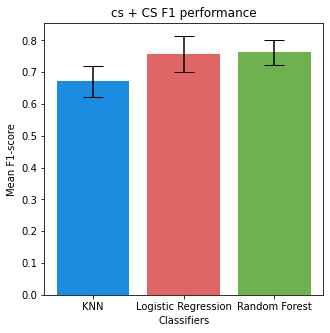

<Figure size 432x288 with 0 Axes>

In [172]:
summary = pd.DataFrame({"classifier": ["KNN", "Logistic Regression", "Random Forest"],
                        "mean_F1": [F1_knn.iloc[1, 5], F1_logReg.iloc[1, 5], F1_ranFor.iloc[1, 5]],
                       "std_F1": [F1_knn.iloc[1, 6], F1_logReg.iloc[1, 6], F1_ranFor.iloc[1, 6]]})

plt.figure(figsize = (5,5))
plt.bar(data = summary, x = "classifier", height = "mean_F1", yerr = "std_F1", color = ["#1b8ce0", "#e06666", "#6eb250"],
        capsize=10)
plt.title("cs + CS F1 performance")
plt.xlabel("Classifiers")
plt.ylabel("Mean F1-score") # put definition of macro F1 score, sensitivity and specificity -> doesnt favour one level over the other
plt.show()
plt.clf()

### All three

In [178]:
df_combi_all = df_combi_ff_cs.merge(features_tf_df[tf_columns], left_index = True, right_index = True)
# df_combi_tf_cs.set_index("sample", inplace = True)
combi_all = df_combi_all.to_numpy(copy = True)
print("No info loss? ", len(combi_all) == len(features_tf_df[tf_columns]) == len(features_cs_df[cs_columns]))

No info loss?  True


In [186]:
n_params = 3
t_knn, t_logReg, t_ranFor = (4,6), (1, 10), (50, 200)

F1_knn, F1_logReg, F1_ranFor = CV_analysis(labels, combi_all, n_params, t_knn, t_logReg, t_ranFor)

In [187]:
F1_logReg, F1_knn, F1_ranFor

(             F1      F2      F3      F4      F5    mean      sd
 C_value                                                        
 1.0      0.8755  0.8519  0.8760  0.8690  0.8696  0.8684  0.0098
 5.5      0.9142  0.8258  0.8622  0.8837  0.8869  0.8745  0.0329
 10.0     0.9142  0.8130  0.8622  0.9018  0.8586  0.8700  0.0400,
                  F1      F2      F3      F4      F5    mean      sd
 n_neighbors                                                        
 4            0.6814  0.6976  0.8649  0.7227  0.8478  0.7629  0.0868
 5            0.6567  0.7205  0.8649  0.7554  0.8478  0.7691  0.0874
 6            0.6814  0.6976  0.8253  0.7462  0.8441  0.7589  0.0735,
                   F1      F2      F3      F4      F5    mean      sd
 n_estimators                                                        
 50            0.8187  0.7703  0.9045  0.8311  0.8831  0.8416  0.0534
 125           0.8399  0.7959  0.8901  0.8311  0.8808  0.8476  0.0384
 200           0.8187  0.8010  0.8901  0.8504  0

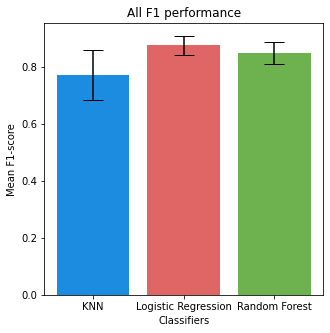

<Figure size 432x288 with 0 Axes>

In [188]:
summary = pd.DataFrame({"classifier": ["KNN", "Logistic Regression", "Random Forest"],
                        "mean_F1": [F1_knn.iloc[1, 5], F1_logReg.iloc[1, 5], F1_ranFor.iloc[1, 5]],
                       "std_F1": [F1_knn.iloc[1, 6], F1_logReg.iloc[1, 6], F1_ranFor.iloc[1, 6]]})

plt.figure(figsize = (5,5))
plt.bar(data = summary, x = "classifier", height = "mean_F1", yerr = "std_F1", color = ["#1b8ce0", "#e06666", "#6eb250"],
        capsize=10)
plt.title("All F1 performance")
plt.xlabel("Classifiers")
plt.ylabel("Mean F1-score") # put definition of macro F1 score, sensitivity and specificity -> doesnt favour one level over the other
plt.show()
plt.clf()

### FINAL MODEL WITH DOMAIN AND MODEL KNOWLEDGE

In [137]:
# run final model with fragment c = 10 om test set
# run final model on prediction for
diagnosis_df =  pd.read_csv("Results/Machine_Learning/sample_map_ML.csv")
features_ff  = pd.read_csv("Results/Machine_Learning/fragment_features_CNA_ML.csv")
features = features_ff.merge(diagnosis_df, on = "sample", how = "inner")

# labels
_, labels_cancer = binary(diagnosis_df, "cancer")
_, labels_A = binary(diagnosis_df, "A", features = False)
_, labels_B = binary(diagnosis_df, "B", features = False)
_, labels_C = binary(diagnosis_df, "C", features = False)
_, labels_lung = binary(diagnosis_df, "Lung", features = False)
_, labels_breast = binary(diagnosis_df, "Breast", features = False)

# features
features_cancer_df, features_cancer = binary(features, "cancer", features = True)
features_A_df, features_A = binary(features, "A", features = True)
features_B_df, features_B = binary(features, "B", features = True)
features_C_df, features_C = binary(features, "C", features = True)
features_lung_df, features_lung = binary(features, "Lung", features = True)
features_breast_df, features_breast = binary(features, "Breast", features = True)

# dict to store all F1 means
all_meanF1 = dict(zip(["Cancer", "Pankreas", "Bilary", "Ovary", "Lung", "Breast"], list(np.zeros(6))))

In [138]:
features_A_df

length,106,107,108,109,110,111,112,113,114,115,...,216,217,218,219,220,221,222,223,224,225
sample,,,,,,,,,,,,,,,,,,,,,
EE87920,60859.0,66366.0,77903.0,107215.0,161056.0,225018.0,232542.0,192520.0,145769.0,119748.0,...,185312.0,176909.0,167818.0,159352.0,151485.0,142983.0,134814.0,126278.0,119530.0,112609.0
EE87921,64643.0,69082.0,79436.0,106027.0,154742.0,212643.0,219668.0,183270.0,140825.0,117512.0,...,165587.0,158046.0,149709.0,142146.0,134738.0,127841.0,119709.0,112096.0,105447.0,98720.0
EE87922,27287.0,30168.0,33931.0,40566.0,49859.0,57925.0,58734.0,52042.0,47575.0,47482.0,...,75693.0,70760.0,66159.0,63012.0,59145.0,55940.0,51594.0,48194.0,44585.0,40738.0
EE87923,28989.0,31499.0,35389.0,41615.0,50517.0,58157.0,59597.0,52749.0,48407.0,48848.0,...,52273.0,49041.0,45823.0,43284.0,40092.0,37875.0,34721.0,32486.0,29447.0,27088.0
EE87924,30650.0,35252.0,38262.0,44578.0,52941.0,59745.0,59744.0,53071.0,49465.0,49993.0,...,50666.0,46780.0,43723.0,40872.0,38698.0,35400.0,32844.0,30085.0,27474.0,25117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EE88320,12860.0,14527.0,16220.0,18502.0,22535.0,25216.0,26718.0,24430.0,23509.0,24646.0,...,32796.0,30312.0,28307.0,26933.0,25309.0,23529.0,21799.0,19824.0,18567.0,16889.0
EE88321,11352.0,12383.0,13520.0,15631.0,18202.0,20007.0,21023.0,19855.0,20100.0,20348.0,...,32172.0,29958.0,27968.0,26134.0,24575.0,22607.0,20850.0,19316.0,17352.0,16041.0
EE88322,17777.0,19979.0,22277.0,26054.0,31678.0,36309.0,38067.0,36417.0,35034.0,35831.0,...,20614.0,19218.0,17841.0,16818.0,15891.0,14731.0,13887.0,12564.0,11615.0,10914.0


In [139]:
all_meanF1 = dict(zip(["Cancer", "Pankreas", "Bilary", "Ovary", "Lung", "Breast"], list(np.zeros(6))))

### Predicting

In [192]:
def fittedLogReg(features, labels, print_report = False, confusion = False):

    X, y = features, labels.ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle = True)
    
    transformer = StandardScaler().fit(X_train) 
    X_test = transformer.transform(X_test)  
    X_train = transformer.transform(X_train)
    
    logReg = LogisticRegression(penalty = "l1", solver = "liblinear", C = 6.) # bigger C lower pen -> 1 / C
    logReg.fit(X_train, y_train)
    y_predicted = logReg.predict(X_test)
    
    if print_report == True:
        print("Report:")
        print(classification_report(y_test, y_predicted))
    
    if confusion == True:
        # plot_confusion_matrix(y_test, y_predicted, cmap = "tab20", colorbar = False)
        plt.figure(figsize = (5, 5))
        cm = confusion_matrix(y_test, y_predicted)
        cm = pd.DataFrame(cm, index = ["Healthy", "Cancer"], columns = ["Healthy", "Cancer"])
        display(cm)
        sns.heatmap(data = cm, annot = True, cbar = False, xticklabels = True, yticklabels = True, cmap = "tab20")
        plt.ylabel("Predicted", fontsize = 35)
        plt.xlabel("True", fontsize = 35)
        plt.savefig("Confusion_matrix.png")

    
    return round(f1_score(y_test, y_predicted, average = "macro"), 2)

Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        46
           1       1.00      0.90      0.95        51

    accuracy                           0.95        97
   macro avg       0.95      0.95      0.95        97
weighted avg       0.95      0.95      0.95        97



,Healthy,Cancer
Healthy,46,0
Cancer,5,46


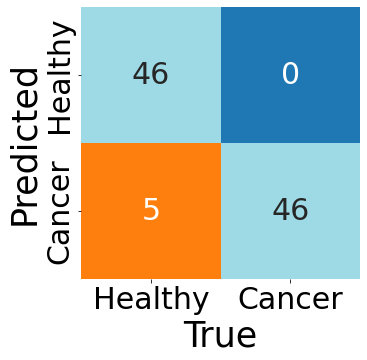

In [193]:
plt.rcParams.update({'font.size': 30})

all_meanF1["Cancer"] = fittedLogReg(features_cancer, labels_cancer, print_report = True, confusion = True)
all_meanF1["Pankreas"] = fittedLogReg(features_A, labels_A, print_report  = False)
all_meanF1["Bilary"] = fittedLogReg(features_B, labels_B)
all_meanF1["Ovary"] = fittedLogReg(features_C, labels_C)
all_meanF1["Lung"] = fittedLogReg(features_lung, labels_lung)
all_meanF1["Breast"] = fittedLogReg(features_breast, labels_breast)

In [142]:
all_df = pd.DataFrame(all_meanF1, index = ["F1_score"]) 
all_df = pd.melt(all_df)
all_df.columns = ["Diagnosis", "F1_score"]
all_df.iloc[:, 0] = ["Cancer\n0.95", "Pancreas\n0.97", "Bilary\n0.82", "Ovary\n0.78", "Lung\n0.87", "Breast\n0.87"]
all_df

,Diagnosis,F1_score
0,Cancer\n0.95,0.95
1,Pancreas\n0.97,0.97
2,Bilary\n0.82,0.82
3,Ovary\n0.78,0.78
4,Lung\n0.87,0.87
5,Breast\n0.87,0.87


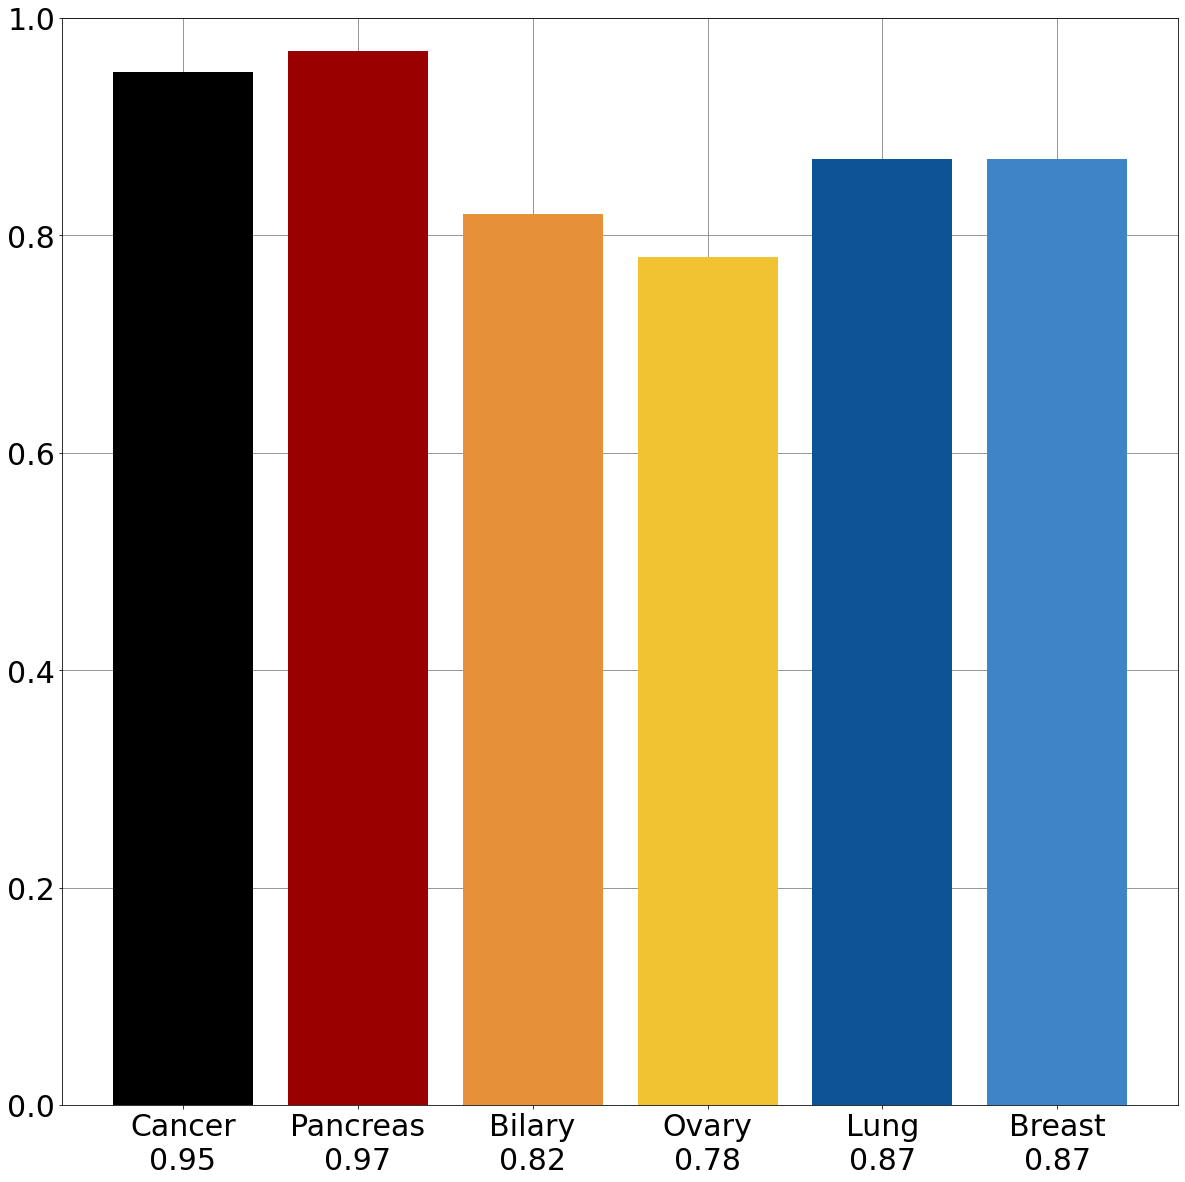

In [143]:
colorlist_healthy = ["#990000", "#e69138", "#f1c232", "#6aa84f", "#0b5394", "#3d85c6"]
colorlist_cancer = ["black","#990000", "#e69138","#f1c232", "#0b5394", "#3d85c6"]

# plot
plt.rcParams.update({'font.size': 30})
plt.figure(figsize = (20,20))
 
plt.bar(data = all_df, x = "Diagnosis", height = "F1_score", color = colorlist_cancer, zorder = 3)
plt.grid(visible = True, color='gray', zorder = 0)# grid should be in background 
# plt.title("F1 scores obtained by final model")
# plt.ylabel("F1 score")
# plt.hlines(y = 0.8, xmin = "Cancer", xmax = "Breast", color = "red")
plt.ylim(0, 1)
plt.savefig("Final_Classification_Result.png")
